# Multiple Linear Regression

Import necessary modules:

In [1]:
import numpy as np
import arviz as az
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy import stats
from scipy.special import gamma
import preliz as pz
import matplotlib as mpl
import pymc as pm
import bambi as bmb

In [2]:
plt.style.use('ggplot')
plt.rcParams["figure.figsize"] = (12,3)

## Credit Data

Read credit data:

In [3]:
credit_data = pd.read_csv("credit_data.csv")
credit_data.head()

,ID,Income,Limit,Rating,Cards,Age,Education,Gender,Student,Married,Ethnicity,Balance
0,1,14.891,3606,283,2,34,11,Male,No,Yes,Caucasian,333
1,2,106.025,6645,483,3,82,15,Female,Yes,Yes,Asian,903
2,3,104.593,7075,514,4,71,11,Male,No,No,Asian,580
3,4,148.924,9504,681,3,36,11,Female,No,No,Asian,964
4,5,55.882,4897,357,2,68,16,Male,No,Yes,Caucasian,331


Simple linear regression:

In [4]:
credit_model1 = bmb.Model( "Balance ~ Limit", data=credit_data, family="gaussian" )
credit_trace1 = credit_model1.fit( draws=2000, tune=2000 )

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, Intercept, Limit]


Output()

Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 3 seconds.


Default computed for conditional variable: Limit


(<Figure size 800x400 with 1 Axes>,
 array([<Axes: xlabel='Limit', ylabel='Balance'>], dtype=object))

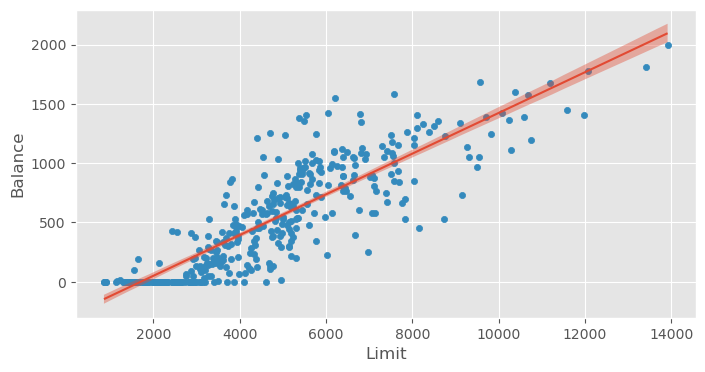

In [5]:
credit_data.plot.scatter( x="Limit", y="Balance", figsize=(8,4) )
bmb.interpret.plot_predictions( credit_model1, credit_trace1, "Limit", prob=0.9, ax=plt.gca() )

In [6]:
pm.summary( credit_trace1 )

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
sigma,234.301,8.240,218.712,249.734,0.072,0.101,13088.0,6315.0,1.0
Intercept,-292.896,27.004,-342.889,-242.956,0.252,0.285,11464.0,6153.0,1.0
Limit,0.172,0.005,0.162,0.181,0.000,0.000,11880.0,6035.0,1.0


$R^2$ score:

In [7]:
credit_model1.predict(credit_trace1, kind="response")
ypred = az.extract( credit_trace1.posterior_predictive ).Balance.values.T
ytrue = credit_data.Balance.values
pm.r2_score( ytrue, ypred )

r2        0.659271
r2_std    0.018800
dtype: float64

Posterior predictive check:

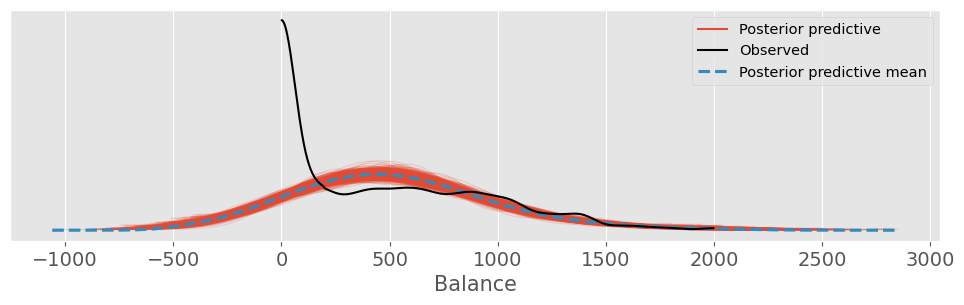

In [8]:
credit_model1.predict( credit_trace1, kind="response" )
pm.plot_ppc( credit_trace1, num_pp_samples=500 );

## More than one variable

In [9]:
credit_data.head()

,ID,Income,Limit,Rating,Cards,Age,Education,Gender,Student,Married,Ethnicity,Balance
0,1,14.891,3606,283,2,34,11,Male,No,Yes,Caucasian,333
1,2,106.025,6645,483,3,82,15,Female,Yes,Yes,Asian,903
2,3,104.593,7075,514,4,71,11,Male,No,No,Asian,580
3,4,148.924,9504,681,3,36,11,Female,No,No,Asian,964
4,5,55.882,4897,357,2,68,16,Male,No,Yes,Caucasian,331


In [10]:
credit_model2 = bmb.Model( "Balance ~ Limit + Income", data=credit_data, family="gaussian" )
credit_trace2 = credit_model2.fit(draws=2000, tune=2000)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, Intercept, Limit, Income]


Output()

Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 4 seconds.


In [11]:
credit_model2

       Formula: Balance ~ Limit + Income
        Family: gaussian
          Link: mu = identity
  Observations: 400
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ Normal(mu: 520.015, sigma: 3008.889)
            Limit ~ Normal(mu: 0.0, sigma: 0.498)
            Income ~ Normal(mu: 0.0, sigma: 32.6123)
        
        Auxiliary parameters
            sigma ~ HalfStudentT(nu: 4.0, sigma: 459.1838)
------
* To see a plot of the priors call the .plot_priors() method.
* To see a summary or plot of the posterior pass the object returned by .fit() to az.summary() or az.plot_trace()

In [12]:
pm.summary( credit_trace2 )

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
sigma,165.992,5.829,154.790,176.602,0.070,0.065,7017.0,5490.0,1.0
Intercept,-384.829,19.553,-422.045,-349.120,0.208,0.178,8818.0,7337.0,1.0
Limit,0.264,0.006,0.253,0.275,0.000,0.000,6517.0,5799.0,1.0
Income,-7.661,0.388,-8.361,-6.927,0.005,0.004,6345.0,5867.0,1.0


In [13]:
credit_model2.predict(credit_trace2, kind="response")
ypred = az.extract( credit_trace2.posterior_predictive ).Balance.values.T
ytrue = credit_data.Balance.values
pm.r2_score( ytrue, ypred )

r2        0.793596
r2_std    0.012851
dtype: float64

Significantly more variance explained with `Income` data.

Posterior predictive check:

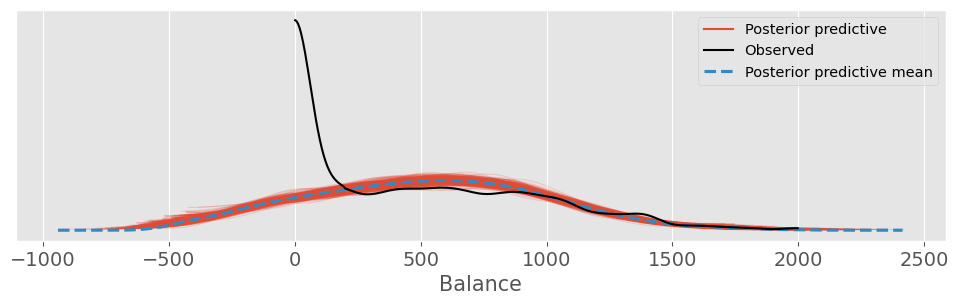

In [14]:
credit_model2.predict( credit_trace2, kind="response" )
pm.plot_ppc( credit_trace2, num_pp_samples=500 );

## Categorical Predictors

In [15]:
credit_data[["Balance", "Income", "Limit", "Student"]].head()

,Balance,Income,Limit,Student
0,333,14.891,3606,No
1,903,106.025,6645,Yes
2,580,104.593,7075,No
3,964,148.924,9504,No
4,331,55.882,4897,No


In [16]:
credit_model3 = bmb.Model( "Balance ~ Limit + Income + Student", data=credit_data, family="gaussian" )
credit_trace3 = credit_model3.fit(draws=2000, tune=2000)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, Intercept, Limit, Income, Student]


Output()

Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 4 seconds.


In [17]:
pm.summary( credit_trace3 )

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
sigma,104.707,3.768,97.419,111.621,0.039,0.044,9177.0,5961.0,1.0
Intercept,-432.226,12.407,-455.250,-408.598,0.128,0.118,9336.0,6945.0,1.0
Limit,0.268,0.004,0.261,0.274,0.000,0.000,6657.0,5326.0,1.0
Income,-7.901,0.240,-8.340,-7.436,0.003,0.003,6597.0,5554.0,1.0
Student[Yes],427.391,17.263,393.839,458.592,0.185,0.198,8695.0,5158.0,1.0


In [18]:
credit_model3.predict(credit_trace3, kind="response")
ypred = az.extract( credit_trace3.posterior_predictive ).Balance.values.T
ytrue = credit_data.Balance.values
pm.r2_score( ytrue, ypred )

r2        0.906215
r2_std    0.006383
dtype: float64

Again a significant improvement! Student status explains a lot of variance!

Posterior predictive check:

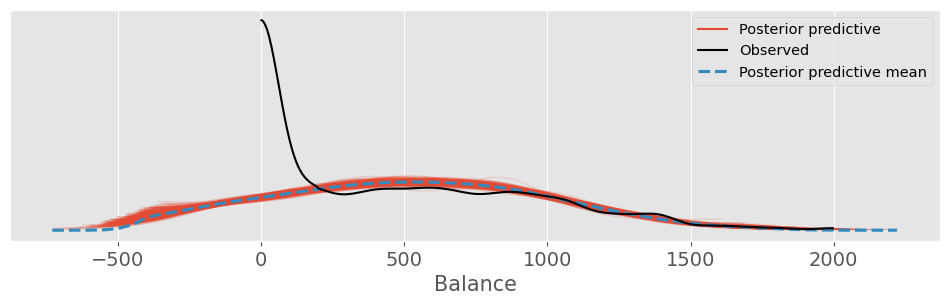

In [19]:
credit_model3.predict( credit_trace3, kind="response" )
pm.plot_ppc( credit_trace3, num_pp_samples=500 );

## Full 'Enchilada'

(all variables)

In [20]:
credit_data.head()

,ID,Income,Limit,Rating,Cards,Age,Education,Gender,Student,Married,Ethnicity,Balance
0,1,14.891,3606,283,2,34,11,Male,No,Yes,Caucasian,333
1,2,106.025,6645,483,3,82,15,Female,Yes,Yes,Asian,903
2,3,104.593,7075,514,4,71,11,Male,No,No,Asian,580
3,4,148.924,9504,681,3,36,11,Female,No,No,Asian,964
4,5,55.882,4897,357,2,68,16,Male,No,Yes,Caucasian,331


In [21]:
credit_model4 = bmb.Model( 
    "Balance ~ Income + Limit + Rating + Cards + Age + Education + Gender + Student + Married + Ethnicity", 
    data=credit_data, 
    family="gaussian" 
)
credit_trace4 = credit_model4.fit(draws=2000, tune=2000)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, Intercept, Income, Limit, Rating, Cards, Age, Education, Gender, Student, Married, Ethnicity]


Output()

Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 22 seconds.


In [22]:
summary = pm.summary( credit_trace4 )
summary

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
sigma,99.101,3.615,92.777,106.353,0.035,0.045,10451.0,5576.0,1.0
Intercept,-479.520,36.047,-544.409,-408.119,0.369,0.421,9586.0,6132.0,1.0
Income,-7.804,0.237,-8.257,-7.362,0.002,0.003,10562.0,5103.0,1.0
Limit,0.190,0.033,0.129,0.252,0.000,0.000,5265.0,5766.0,1.0
Rating,1.151,0.494,0.217,2.061,0.007,0.005,5197.0,5691.0,1.0
Cards,17.604,4.379,9.161,25.706,0.052,0.046,7036.0,6061.0,1.0
Age,-0.613,0.295,-1.156,-0.043,0.003,0.003,10230.0,5772.0,1.0
Education,-1.108,1.604,-4.015,1.967,0.015,0.021,11960.0,5291.0,1.0
Gender[Female],-10.645,9.826,-29.074,7.623,0.089,0.118,12274.0,5667.0,1.0
Student[Yes],425.743,16.821,394.382,457.340,0.164,0.201,10585.0,6111.0,1.0


In [23]:
credit_data.Ethnicity.unique()

array(['Caucasian', 'Asian', 'African American'], dtype=object)

Only significant predictors:

In [24]:
summary[summary["hdi_3%"] * summary["hdi_97%"] > 0]

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
sigma,99.101,3.615,92.777,106.353,0.035,0.045,10451.0,5576.0,1.0
Intercept,-479.520,36.047,-544.409,-408.119,0.369,0.421,9586.0,6132.0,1.0
Income,-7.804,0.237,-8.257,-7.362,0.002,0.003,10562.0,5103.0,1.0
Limit,0.190,0.033,0.129,0.252,0.000,0.000,5265.0,5766.0,1.0
Rating,1.151,0.494,0.217,2.061,0.007,0.005,5197.0,5691.0,1.0
Cards,17.604,4.379,9.161,25.706,0.052,0.046,7036.0,6061.0,1.0
Age,-0.613,0.295,-1.156,-0.043,0.003,0.003,10230.0,5772.0,1.0
Student[Yes],425.743,16.821,394.382,457.340,0.164,0.201,10585.0,6111.0,1.0


Performance:

In [25]:
credit_model4.predict(credit_trace4, kind="response")
ypred = az.extract( credit_trace4.posterior_predictive ).Balance.values.T
ytrue = credit_data.Balance.values
pm.r2_score( ytrue, ypred )

r2        0.915310
r2_std    0.005887
dtype: float64

Posterior predictive test:

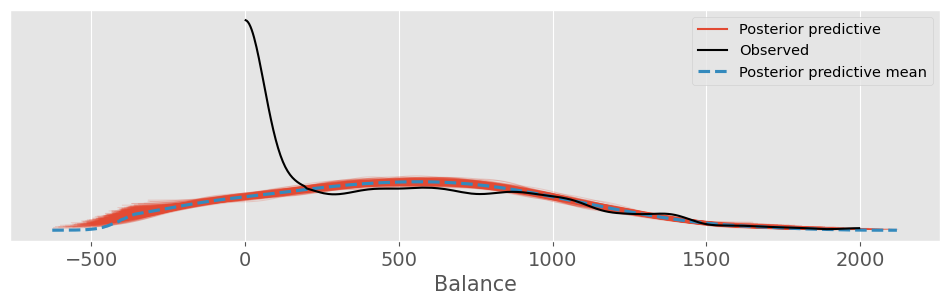

In [26]:
credit_model4.predict( credit_trace4, kind="response" )
pm.plot_ppc( credit_trace4, num_pp_samples=500 );

## Interactions

Read data:

In [27]:
adv_data = pd.read_csv("advertising.csv")
adv_data.head()

,TV,radio,newspaper,sales
0,230.1,37.8,69.2,22.1
1,44.5,39.3,45.1,10.4
2,17.2,45.9,69.3,9.3
3,151.5,41.3,58.5,18.5
4,180.8,10.8,58.4,12.9


Marginal plots:

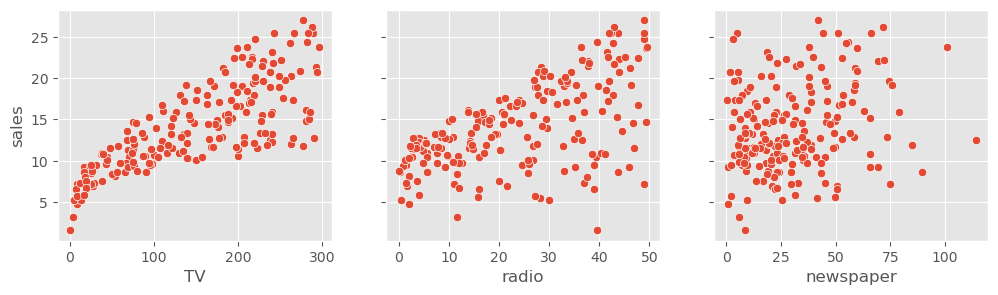

In [28]:
fig, ax = plt.subplots( 1, 3, figsize=(12,3), sharey=True )
for i, x in enumerate(['TV', 'radio', 'newspaper']):
    sns.scatterplot( data=adv_data, x=x, y="sales", ax=ax[i] )

Fit a model without interactions:

In [29]:
adv_model1 = bmb.Model( "sales ~ TV + radio + newspaper", data=adv_data, family="gaussian" )
adv_trace1 = adv_model1.fit(draws=2000, tune=2000)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, Intercept, TV, radio, newspaper]


Output()

Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 3 seconds.


In [30]:
pm.summary( adv_trace1 )

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
sigma,1.695,0.087,1.533,1.857,0.001,0.001,10905.0,6919.0,1.0
Intercept,2.941,0.316,2.368,3.551,0.003,0.004,13486.0,6937.0,1.0
TV,0.046,0.001,0.043,0.048,0.000,0.000,13744.0,7236.0,1.0
radio,0.189,0.009,0.172,0.205,0.000,0.000,8291.0,6417.0,1.0
newspaper,-0.001,0.006,-0.012,0.010,0.000,0.000,9108.0,6804.0,1.0


newspaper is not significant at the 94% level (HDI includes zero).

$R^2$ and RMSE:

In [31]:
adv_model1.predict(adv_trace1, kind="response")
ypred = az.extract( adv_trace1.posterior_predictive ).sales.values.T
ytrue = adv_data.sales.values
pm.r2_score( ytrue, ypred )

r2        0.826769
r2_std    0.015695
dtype: float64

In [32]:
np.sqrt( np.mean( (ypred-ytrue)**2 ) )

np.float64(2.3915150703391395)

Residual contour plot to motivate interaction:

In [33]:
mean_residuals = np.mean( ytrue-ypred, axis=0 )
mean_residuals.shape

(200,)

Text(0.5, 1.0, 'Mean residuals $\\hat{y}_i - y_i$')

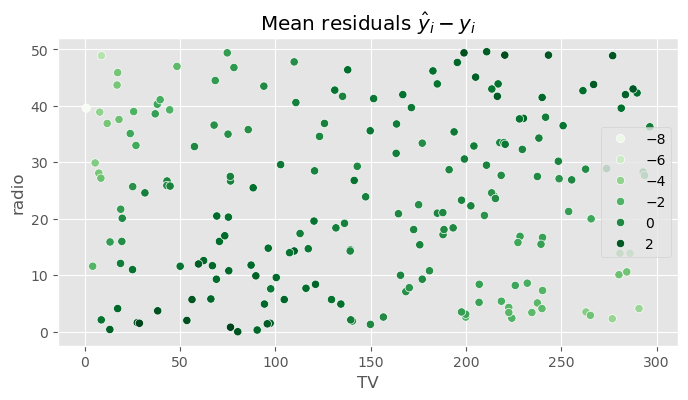

In [34]:
plt.figure( figsize=(8,4) )
sns.scatterplot(data=adv_data, x="TV", y="radio", hue=mean_residuals, palette="Greens")
plt.title("Mean residuals $\hat{y}_i - y_i$")

Posterior predictive test:

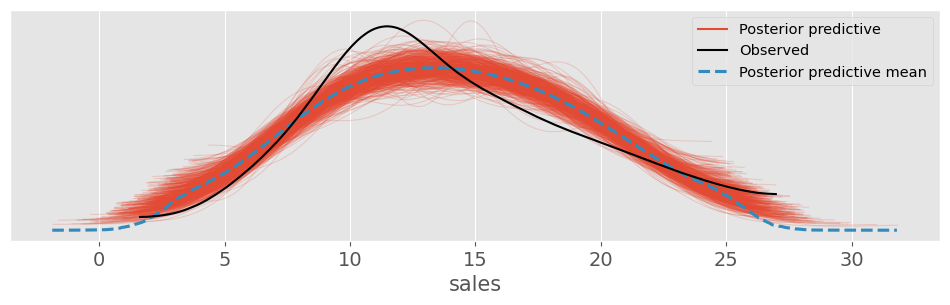

In [35]:
adv_model1.predict( adv_trace1, kind="response" )
pm.plot_ppc( adv_trace1, num_pp_samples=500 );

Model with interaction:

In [36]:
adv_model2 = bmb.Model( "sales ~ TV + radio + TV:radio", data=adv_data, family="gaussian" )
adv_trace2 = adv_model2.fit(draws=2000, tune=2000)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, Intercept, TV, radio, TV:radio]


Output()

Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 5 seconds.


In [37]:
pm.summary( adv_trace2 )

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
sigma,0.949,0.048,0.863,1.040,0.001,0.001,7155.0,5841.0,1.0
Intercept,6.749,0.250,6.293,7.227,0.004,0.003,3311.0,4465.0,1.0
TV,0.019,0.002,0.016,0.022,0.000,0.000,3171.0,4130.0,1.0
radio,0.029,0.009,0.013,0.046,0.000,0.000,3134.0,4233.0,1.0
TV:radio,0.001,0.000,0.001,0.001,0.000,0.000,2917.0,3831.0,1.0


Interaction between TV and radio is significant.

Change in $R^2$ and RMSE:

In [38]:
adv_model2.predict(adv_trace2, kind="response")
ypred = az.extract( adv_trace2.posterior_predictive ).sales.values.T
ytrue = adv_data.sales.values
pm.r2_score( ytrue, ypred )

r2        0.938248
r2_std    0.006096
dtype: float64

In [39]:
np.sqrt( np.mean( (ytrue-ypred)**2 ) )

np.float64(1.3392983394061955)

Posterior predictive test:

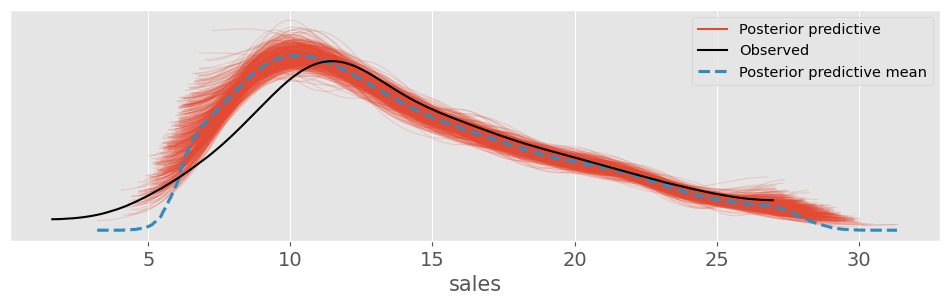

In [40]:
adv_model2.predict( adv_trace2, kind="response" )
pm.plot_ppc( adv_trace2, num_pp_samples=500 );